In [1]:
import os
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent

DATA_PATH = PROJECT_ROOT / "data" / "processed" / "CDC_Diabetes_Dataset_clean.csv"
FIG_DIR = PROJECT_ROOT / "figures" / "results_multi"
FIG_DIR.mkdir(parents=True, exist_ok=True)


print("Project root directory:", PROJECT_ROOT)
print("Data path exists:", DATA_PATH.exists())
assert DATA_PATH.exists(), f"Data file not found at {DATA_PATH}"
print("Figures directory:", FIG_DIR)

Project root directory: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk
Data path exists: True
Figures directory: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_multi


In [2]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dataclasses import dataclass
from typing import Dict, Any, List

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score, 
    classification_report, confusion_matrix, log_loss, precision_recall_fscore_support, recall_score, 
    brier_score_loss, roc_auc_score)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.base import clone

from xgboost import XGBClassifier
import optuna

import shap
from lime.lime_tabular import LimeTabularExplainer

/Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

In [4]:
# -------------------------------
# Experiment management utilities
# -------------------------------



# Each ExperimentResult object stores the outcome of one model run
# This is purely for organisation and comparison and not modelling

@dataclass
class ExperimentResult:
    exp_id: str                 # Unique experiment name (used in report)
    model_family: str           # e.g. "LR", "XGB"
    features: str               # e.g. "raw", "feateng"
    sampling: str               # "none", "classweight", "smote"
    tuning: str                 # "default", "grid", "optuna"
    notes: str                  # Short description
    metrics: Dict[str, float]   # Evaluation metrics (F1, log loss, etc.)
    params: Dict[str, Any]      # Model hyperparameters


# List that will store ALL experiments run in this notebook
results: List[ExperimentResult] = []


def log_experiment(
    exp_id: str,
    model_family: str,
    features: str,
    sampling: str,
    tuning: str,
    notes: str,
    metrics: Dict[str, float],
    params: Dict[str, Any]
):
    """
    Store the results of a single experiment in a structured way.
    This function is called once per model run.
    """
    results.append(
        ExperimentResult(
            exp_id=exp_id,
            model_family=model_family,
            features=features,
            sampling=sampling,
            tuning=tuning,
            notes=notes,
            metrics=metrics,
            params=params
        )
    )


def results_df() -> pd.DataFrame:
    """
    Convert all logged experiments into a pandas DataFrame
    for easy comparison and reporting.
    """
    if not results:
        return pd.DataFrame()

    rows = []
    for r in results:
        row = {
            "experiment": r.exp_id,
            "model": r.model_family,
            "features": r.features,
            "sampling": r.sampling,
            "tuning": r.tuning,
            "notes": r.notes,
        }

        # Add metrics with a prefix to avoid name clashes
        for k, v in r.metrics.items():
            row[f"metric__{k}"] = v

        rows.append(row)

    return pd.DataFrame(rows)


print("Step 0 complete: experiment logger initialised.")

Step 0 complete: experiment logger initialised.


In [5]:
# ---------------------------------------
# Setup: imports, paths, utilities
# ---------------------------------------

def savefig(name: str):
    """
    Save the current matplotlib figure to the figures directory
    at publication-quality resolution.
    """
    plt.savefig(FIG_DIR / name, dpi=300, bbox_inches="tight")
    print(f"Figure saved: {FIG_DIR / name}")

In [6]:
# load data from csv
data = pd.read_csv(DATA_PATH)
print("Data loaded successfully.")
print("Top 5 rows:")
data.head()



Data loaded successfully.
Top 5 rows:


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


**Baseline multinomial Logistic Regression**

In [7]:
# =======================================
# Raw feature set - baseline
# =======================================

target = "Diabetes_012"

binary_features = [
    "HighBP","HighChol","CholCheck","Smoker","Stroke","HeartDiseaseorAttack",
    "PhysActivity","Fruits","Veggies","HvyAlcoholConsump","AnyHealthcare",
    "NoDocbcCost","DiffWalk","Sex"]

ordinal_features = ["GenHlth","Age","Education","Income"]
numeric_features  = ["BMI","MentHlth","PhysHlth"]

feature_cols = binary_features + ordinal_features + numeric_features

X = data[feature_cols].copy()
y = data[target].astype(int)
print("X shape", X.shape)
print("Class balance(%):")
print((y.value_counts(normalize=True).sort_index() * 100).round(2))



X shape (229781, 21)
Class balance(%):
Diabetes_012
0    82.71
1     2.01
2    15.27
Name: proportion, dtype: float64


In [8]:
X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

X_eval_raw, X_test_raw, y_eval, y_test = train_test_split(
    X_temp_raw, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Train:", X_train_raw.shape, "\nEval:", X_eval_raw.shape, "\nTest:", X_test_raw.shape)

print("\nClass % (train):")
print((y_train.value_counts(normalize=True).sort_index()*100).round(2))
print("\nClass % (eval):")
print((y_eval.value_counts(normalize=True).sort_index()*100).round(2))
print("\nClass % (test):")
print((y_test.value_counts(normalize=True).sort_index()*100).round(2))


Train: (160846, 21) 
Eval: (34467, 21) 
Test: (34468, 21)

Class % (train):
Diabetes_012
0    82.71
1     2.01
2    15.27
Name: proportion, dtype: float64

Class % (eval):
Diabetes_012
0    82.71
1     2.02
2    15.27
Name: proportion, dtype: float64

Class % (test):
Diabetes_012
0    82.71
1     2.01
2    15.28
Name: proportion, dtype: float64


In [9]:
def evaluate_multiclass_classifier(y_true, y_pred, y_proba, labels=(0,1,2)):
    """
    Comprehensive evaluation metrics for multiclass classification.
    Includes per-class metrics, macro/weighted averages, ROC-AUC, and Brier score.
    """
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=labels, zero_division=0
    )

    # Brier score (multiclass)
    Y = label_binarize(y_true, classes=list(labels))  # one-hot encode
    P = np.asarray(y_proba)
    brier = float(np.mean(np.sum((P - Y) ** 2, axis=1)))

    metrics = {
        # Overall metrics
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        
        # F1 scores
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted", zero_division=0),
        
        # Probabilistic metrics
        "log_loss": log_loss(y_true, y_proba, labels=list(labels)),
        "brier_score": brier,  # ✅ ADDED
        
        # ROC-AUC scores
        "roc_auc_ovr_macro": roc_auc_score(y_true, y_proba, multi_class="ovr", average="macro"),
        "roc_auc_ovr_weighted": roc_auc_score(y_true, y_proba, multi_class="ovr", average="weighted"),
        "roc_auc_ovo_macro": roc_auc_score(y_true, y_proba, multi_class="ovo", average="macro"),
    }

    # Per-class metrics
    for i, lbl in enumerate(labels):
        metrics[f"precision_class_{lbl}"] = precision[i]
        metrics[f"recall_class_{lbl}"] = recall[i]
        metrics[f"f1_class_{lbl}"] = f1[i]
        metrics[f"support_class_{lbl}"] = int(support[i])

    # "At-risk" recall (classes 1 or 2 vs. class 0)
    y_true_risk = np.isin(y_true, [1, 2]).astype(int)
    y_pred_risk = np.isin(y_pred, [1, 2]).astype(int)
    metrics["recall_at_risk_1or2"] = recall_score(y_true_risk, y_pred_risk, zero_division=0)
    
    # Precision for at-risk detection
    from sklearn.metrics import precision_score
    metrics["precision_at_risk_1or2"] = precision_score(y_true_risk, y_pred_risk, zero_division=0)
    
    # F1 for at-risk detection
    metrics["f1_at_risk_1or2"] = f1_score(y_true_risk, y_pred_risk, zero_division=0)

    return metrics

In [10]:
# Preprocess: scale ordinal + numeric, keep binary as-is
preprocess_raw = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("ord", StandardScaler(), ordinal_features),
        ("bin", "passthrough", binary_features),
    ],
    remainder="drop"
)

lr_raw_none_default = Pipeline(steps=[
    ("preprocess", preprocess_raw),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=5000,
        random_state=42,
        class_weight=None #baseline, class is not balanced
    ))
])
# sklearn handles multiclass automatically with lbfgs solver

print("Logistic regression baseline pipeline built ✅")

Logistic regression baseline pipeline built ✅


{'accuracy': 0.8326515217454377, 'balanced_accuracy': 0.38156946897289284, 'f1_macro': 0.3882145842170281, 'f1_weighted': 0.7894741003595996, 'log_loss': 0.43078556198041706, 'brier_score': 0.24355802470468782, 'roc_auc_ovr_macro': 0.768864542490744, 'roc_auc_ovr_weighted': 0.8062759947016575, 'roc_auc_ovo_macro': np.float64(0.691009930974451), 'precision_class_0': np.float64(0.8473656946095012), 'recall_class_0': np.float64(0.975445488985548), 'f1_class_0': np.float64(0.9069058295964125), 'support_class_0': 28508, 'precision_class_1': np.float64(0.0), 'recall_class_1': np.float64(0.0), 'f1_class_1': np.float64(0.0), 'support_class_1': 695, 'precision_class_2': np.float64(0.54), 'recall_class_2': np.float64(0.1692629179331307), 'f1_class_2': np.float64(0.2577379230546717), 'support_class_2': 5264, 'recall_at_risk_1or2': 0.15942272193321028, 'precision_at_risk_1or2': 0.5757575757575758, 'f1_at_risk_1or2': 0.24970429754238402}

Confusion matrix:
 [[27808     0   700]
 [  636     0    59]

/Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is 

,No Diabetes,Prediabetes,Diabetes
No Diabetes,27808 (97.5%),0 (0.0%),700 (2.5%)
Prediabetes,636 (91.5%),0 (0.0%),59 (8.5%)
Diabetes,4373 (83.1%),0 (0.0%),891 (16.9%)


Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_multi/confusion_matrix_lr_baseline_eval.png


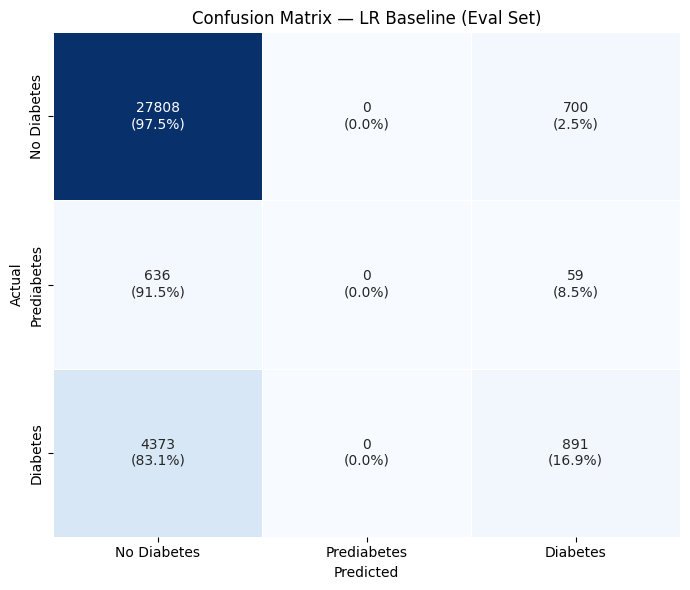

In [30]:
# Fit on train set
lr_raw_none_default.fit(X_train_raw, y_train)

# Predict on eval set
y_pred_base = lr_raw_none_default.predict(X_eval_raw)
y_proba_base = lr_raw_none_default.predict_proba(X_eval_raw)

# Evaluate on eval set
metrics_lr_base = evaluate_multiclass_classifier(y_eval, y_pred_base, y_proba_base)
print(metrics_lr_base)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_base))
print("\nClassification report:\n", classification_report(y_eval, y_pred_base, digits=3))

# Log (baseline)
log_experiment(
    exp_id="LR__raw__none__default",
    model_family="LR",
    features="raw",
    sampling="none",
    tuning="default",
    notes="Baseline LR on raw features (no class weighting), evaluated on validation set",
    metrics=metrics_lr_base,
    params=lr_raw_none_default.get_params()
)

results_df()

# ==========================
# Report-ready confusion matrix (counts + row %), LR baseline
# ==========================
class_names = ["No Diabetes", "Prediabetes", "Diabetes"]

# Confusion matrix (counts)
cm_lr = confusion_matrix(y_eval, y_pred_base, labels=[0, 1, 2])
cm_lr_df = pd.DataFrame(cm_lr, index=class_names, columns=class_names)

# Row-normalized percentages
cm_lr_row_pct = cm_lr_df.div(cm_lr_df.sum(axis=1), axis=0) * 100

# Combine counts + percentages for annotation
cm_lr_annot = cm_lr_df.astype(int).astype(str) + "\n(" + cm_lr_row_pct.round(1).astype(str) + "%)"

# Display table (counts + row %) for direct copy into report
cm_lr_table = cm_lr_df.copy()
for r in cm_lr_table.index:
    for c in cm_lr_table.columns:
        cm_lr_table.loc[r, c] = f"{cm_lr_df.loc[r, c]} ({cm_lr_row_pct.loc[r, c]:.1f}%)"

print("Confusion matrix (counts and row %):")
display(cm_lr_table)

# Plot heatmap for report-ready figure
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_lr_df,
    annot=cm_lr_annot,
    fmt="",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor="white"
 )
plt.title("Confusion Matrix — LR Baseline (Eval Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
savefig("confusion_matrix_lr_baseline_eval.png")
plt.show()

{'accuracy': 0.6294716685525285, 'balanced_accuracy': 0.5146383476598931, 'f1_macro': 0.42627211862900066, 'f1_weighted': 0.7033879901167976, 'log_loss': 0.9040425762416514, 'brier_score': 0.5077917397463714, 'roc_auc_ovr_macro': 0.7601431138521514, 'roc_auc_ovr_weighted': 0.804890889832732, 'roc_auc_ovo_macro': np.float64(0.7007334075875828), 'precision_class_0': np.float64(0.9431333230500283), 'recall_class_0': np.float64(0.643433422197278), 'f1_class_0': np.float64(0.7649769585253456), 'support_class_0': 28508, 'precision_class_1': np.float64(0.03261709692379038), 'recall_class_1': np.float64(0.3035971223021583), 'f1_class_1': np.float64(0.05890563930764936), 'support_class_1': 695, 'precision_class_2': np.float64(0.36752836589074744), 'recall_class_2': np.float64(0.5968844984802432), 'f1_class_2': np.float64(0.4549337580540071), 'support_class_2': 5264, 'recall_at_risk_1or2': 0.8143983889914416, 'precision_at_risk_1or2': 0.3231455586629378, 'f1_at_risk_1or2': 0.46269723983410405}



/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_57649/3312155332.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '18343 (64.3%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_lr_cw_table.loc[r, c] = f"{cm_lr_cw_df.loc[r, c]} ({cm_lr_cw_row_pct.loc[r, c]:.1f}%)"
/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_57649/3312155332.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5043 (17.7%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_lr_cw_table.loc[r, c] = f"{cm_lr_cw_df.loc[r, c]} ({cm_lr_cw_row_pct.loc[r, c]:.1f}%)"
/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_57649/3312155332.py:64: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future ver

,No Diabetes,Prediabetes,Diabetes
No Diabetes,18343 (64.3%),5043 (17.7%),5122 (18.0%)
Prediabetes,199 (28.6%),211 (30.4%),285 (41.0%)
Diabetes,907 (17.2%),1215 (23.1%),3142 (59.7%)


Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_multi/confusion_matrix_lr_balanced_eval.png


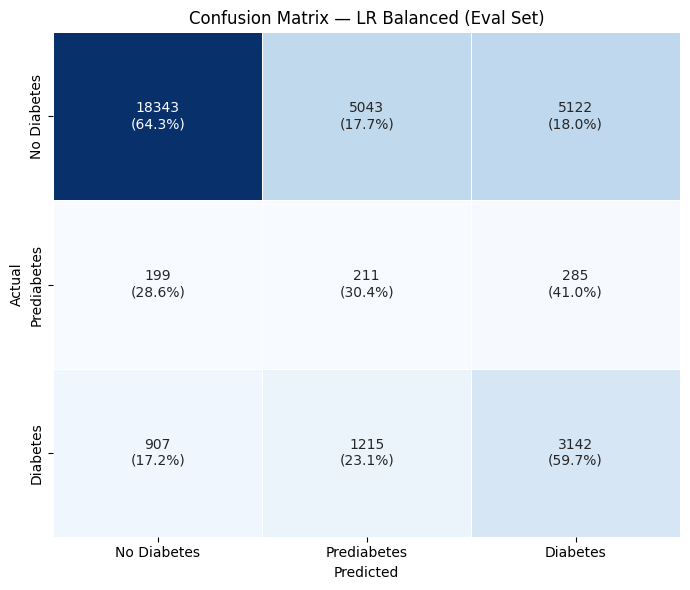

In [31]:
# ==========================
# 2nd Model: Balanced LR
# LR__raw__classweight__default
# ==========================

lr_raw_classweight_default = Pipeline(steps=[
    ("preprocess", preprocess_raw),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=5000,
        random_state=42,
        class_weight="balanced"   # only change vs baseline
    ))
])

# Fit on TRAIN
lr_raw_classweight_default.fit(X_train_raw, y_train)

# Predict on EVAL (NOT test)
y_pred_cw = lr_raw_classweight_default.predict(X_eval_raw)
y_proba_cw = lr_raw_classweight_default.predict_proba(X_eval_raw)

# Evaluate on EVAL
metrics_lr_cw = evaluate_multiclass_classifier(y_eval, y_pred_cw, y_proba_cw)
print(metrics_lr_cw)

# Diagnostics
print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_cw))
print("\nClassification report:\n", classification_report(y_eval, y_pred_cw, digits=3))

# Log experiment
log_experiment(
    exp_id="LR__raw__classweight__default",
    model_family="LR",
    features="raw",
    sampling="classweight",
    tuning="default",
    notes="LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set)",
    metrics=metrics_lr_cw,
    params=lr_raw_classweight_default.get_params()
)

results_df()

# ==========================
# Report-ready confusion matrix (counts + row %), LR balanced
# ==========================
class_names = ["No Diabetes", "Prediabetes", "Diabetes"]

# Confusion matrix (counts)
cm_lr_cw = confusion_matrix(y_eval, y_pred_cw, labels=[0, 1, 2])
cm_lr_cw_df = pd.DataFrame(cm_lr_cw, index=class_names, columns=class_names)

# Row-normalized percentages
cm_lr_cw_row_pct = cm_lr_cw_df.div(cm_lr_cw_df.sum(axis=1), axis=0) * 100

# Combine counts + percentages for annotation
cm_lr_cw_annot = cm_lr_cw_df.astype(int).astype(str) + "\n(" + cm_lr_cw_row_pct.round(1).astype(str) + "%)"

# Display table (counts + row %) for direct copy into report
cm_lr_cw_table = cm_lr_cw_df.copy()
for r in cm_lr_cw_table.index:
    for c in cm_lr_cw_table.columns:
        cm_lr_cw_table.loc[r, c] = f"{cm_lr_cw_df.loc[r, c]} ({cm_lr_cw_row_pct.loc[r, c]:.1f}%)"

print("Confusion matrix (counts and row %):")
display(cm_lr_cw_table)

# Plot heatmap for report-ready figure
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_lr_cw_df,
    annot=cm_lr_cw_annot,
    fmt="",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor="white"
 )
plt.title("Confusion Matrix — LR Balanced (Eval Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
savefig("confusion_matrix_lr_balanced_eval.png")
plt.show()

**Feature engineering**
- Now that a model baseline has been established, its important to engineer features


Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_multi/corr_matrix_raw_train.png


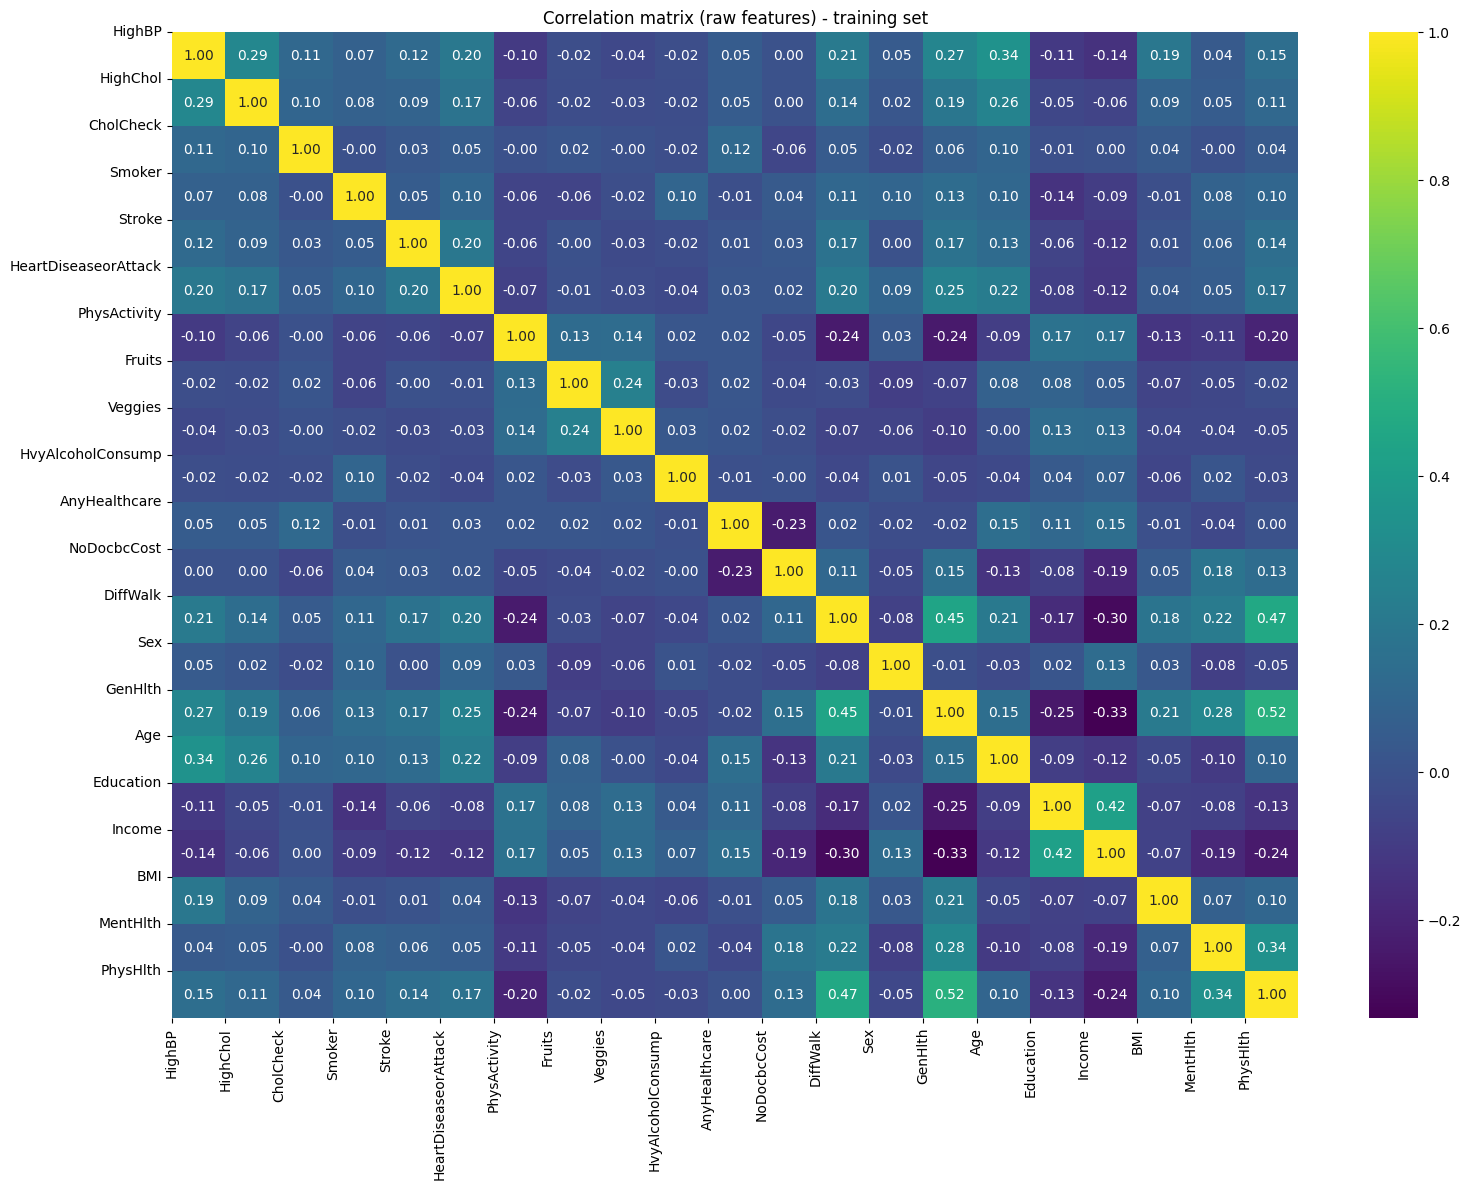

In [13]:
corr = X_train_raw.corr(numeric_only=True)
plt.figure(figsize=(16, 12))
sns.heatmap(corr, cmap = 'viridis', annot=True, fmt=".2f")
plt.title("Correlation matrix (raw features) - training set")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
savefig("corr_matrix_raw_train.png")
plt.show()


In [14]:
# List of highly correlated features, threshold = 0.7 (initial value)
# unable to fully identify from the graph

# Find highly correlated feature pairs (absolute corr >= threshold)
threshold = 0.4

corr_abs = corr.abs()
upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(bool))

high_corr_pairs = (
    upper.stack()
    .reset_index()
    .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "abs_corr"})
    .sort_values("abs_corr", ascending=False)
)

high_corr_pairs_filtered = high_corr_pairs[high_corr_pairs["abs_corr"] >= threshold]

print(f"Number of pairs with abs(corr) >= {threshold}: {len(high_corr_pairs_filtered)}")
high_corr_pairs_filtered.head(20)

Number of pairs with abs(corr) >= 0.4: 4


,feature_1,feature_2,abs_corr
194,GenHlth,PhysHlth,0.515053
181,DiffWalk,PhysHlth,0.466096
175,DiffWalk,GenHlth,0.447158
200,Education,Income,0.420146


**Create new features**

In [15]:
# Create features
# 1 RiskFactorCount = sum of major risk flags - captures cumulative burden
# 2 BMI x physical activity interaction - BMI changes depending on activity
# 3 Age x high BP - BP risk increases with age
# 4 log1p mental health and physical health. they are skewed. 

# ===========================
# Create feature set A
# ===========================

X_train_fe_A = X_train_raw.copy()
X_test_fe_A = X_test_raw.copy()
X_eval_fe_A = X_eval_raw.copy()

# Add features
# 1 RiskFactorCount
risk_flags_A = ["HighBP","HighChol","Smoker","Stroke","HeartDiseaseorAttack","DiffWalk"]
X_train_fe_A["RiskFactorCount"] = X_train_fe_A[risk_flags_A].sum(axis=1)
X_test_fe_A["RiskFactorCount"] = X_test_fe_A[risk_flags_A].sum(axis=1)
X_eval_fe_A["RiskFactorCount"] = X_eval_fe_A[risk_flags_A].sum(axis=1)

# 2 BMI x physical activity interaction
X_train_fe_A["BMI_PhysActivity"] = X_train_fe_A["BMI"] * X_train_fe_A["PhysActivity"]
X_test_fe_A["BMI_PhysActivity"] = X_test_fe_A["BMI"] * X_test_fe_A["PhysActivity"]
X_eval_fe_A["BMI_PhysActivity"] = X_eval_fe_A["BMI"] * X_eval_fe_A["PhysActivity"]

# 3 Age x high BP interaction
X_train_fe_A["Age_HighBP"] = X_train_fe_A["Age"] * X_train_fe_A["HighBP"]
X_test_fe_A["Age_HighBP"] = X_test_fe_A["Age"] * X_test_fe_A["HighBP"]
X_eval_fe_A["Age_HighBP"] = X_eval_fe_A["Age"] * X_eval_fe_A["HighBP"]

# 4 log1p mental health and physical health (skewed)
X_train_fe_A["Log1p_MentHlth"] = np.log1p(X_train_fe_A["MentHlth"])
X_test_fe_A["Log1p_MentHlth"] = np.log1p(X_test_fe_A["MentHlth"])
X_eval_fe_A["Log1p_MentHlth"] = np.log1p(X_eval_fe_A["MentHlth"])
X_train_fe_A["Log1p_PhysHlth"] = np.log1p(X_train_fe_A["PhysHlth"])
X_test_fe_A["Log1p_PhysHlth"] = np.log1p(X_test_fe_A["PhysHlth"])
X_eval_fe_A["Log1p_PhysHlth"] = np.log1p(X_eval_fe_A["PhysHlth"])

# check everything worked as planned
print("Feature set A created")
print("Raw feature count: ", X_train_raw.shape[1])
print("Engineered feature count: ", X_train_fe_A.shape[1])

new_columns_A = ["RiskFactorCount", "BMI_PhysActivity", "Age_HighBP", "Log1p_MentHlth", "Log1p_PhysHlth"]

print ("New columns added in train:", all(c in X_train_fe_A.columns for c in new_columns_A))
print ("New columns added in test:", all(c in X_test_fe_A.columns for c in new_columns_A))
print ("New columns added in eval:", all(c in X_eval_fe_A.columns for c in new_columns_A))

Feature set A created
Raw feature count:  21
Engineered feature count:  26
New columns added in train: True
New columns added in test: True
New columns added in eval: True


In [16]:
# ==========================
# create 3rd model, LR on Feature Set A (no balancing)
# LR__featA__none__default
# ==========================

# 1) Update feature lists to include engineered numeric columns
engineered_numeric_A = ["RiskFactorCount", "BMI_PhysActivity", "Age_HighBP", "Log1p_MentHlth", "Log1p_PhysHlth"]
numeric_features_A = numeric_features + engineered_numeric_A

preprocess_featA = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_A),
        ("ord", StandardScaler(), ordinal_features),
        ("bin", "passthrough", binary_features),
    ],
    remainder="drop"
)

lr_featA_none_default = Pipeline(steps=[
    ("preprocess", preprocess_featA),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=5000,
        random_state=42,
        class_weight=None
    ))
])

# 2) Fit on TRAIN
lr_featA_none_default.fit(X_train_fe_A, y_train)

# 3) Evaluate on EVAL
y_pred_featA = lr_featA_none_default.predict(X_eval_fe_A)
y_proba_featA = lr_featA_none_default.predict_proba(X_eval_fe_A)

metrics_lr_featA = evaluate_multiclass_classifier(y_eval, y_pred_featA, y_proba_featA)
print(metrics_lr_featA)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_featA))
print("\nClassification report:\n", classification_report(y_eval, y_pred_featA, digits=3))

log_experiment(
    exp_id="LR__featA__none__default",
    model_family="LR",
    features="featA",
    sampling="none",
    tuning="default",
    notes="LR on Feature Set A engineered features, no balancing (eval set)",
    metrics=metrics_lr_featA,
    params=lr_featA_none_default.get_params()
)

results_df()

{'accuracy': 0.8326225084863783, 'balanced_accuracy': 0.38011212018340285, 'f1_macro': 0.38620437871480773, 'f1_weighted': 0.7885983382091072, 'log_loss': 0.43002944316455527, 'brier_score': 0.24304879200992177, 'roc_auc_ovr_macro': 0.7692517826287508, 'roc_auc_ovr_weighted': 0.8065580925896767, 'roc_auc_ovo_macro': np.float64(0.6916120492666815), 'precision_class_0': np.float64(0.8467692869311267), 'recall_class_0': np.float64(0.9763925915532482), 'f1_class_0': np.float64(0.9069729553600522), 'support_class_0': 28508, 'precision_class_1': np.float64(0.0), 'recall_class_1': np.float64(0.0), 'f1_class_1': np.float64(0.0), 'support_class_1': 695, 'precision_class_2': np.float64(0.5410658307210031), 'recall_class_2': np.float64(0.16394376899696048), 'f1_class_2': np.float64(0.2516401807843709), 'support_class_2': 5264, 'recall_at_risk_1or2': 0.15472394697096828, 'precision_at_risk_1or2': 0.5780564263322884, 'f1_at_risk_1or2': 0.2441090812814403}

Confusion matrix:
 [[27835     0   673]
 [

/Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is 

,experiment,model,features,sampling,tuning,notes,metric__accuracy,metric__balanced_accuracy,metric__f1_macro,metric__f1_weighted,metric__log_loss,metric__brier_score,metric__roc_auc_ovr_macro,metric__roc_auc_ovr_weighted,metric__roc_auc_ovo_macro,metric__precision_class_0,metric__recall_class_0,metric__f1_class_0,metric__support_class_0,metric__precision_class_1,metric__recall_class_1,metric__f1_class_1,metric__support_class_1,metric__precision_class_2,metric__recall_class_2,metric__f1_class_2,metric__support_class_2,metric__recall_at_risk_1or2,metric__precision_at_risk_1or2,metric__f1_at_risk_1or2
0,LR__raw__none__default,LR,raw,none,default,"Baseline LR on raw features (no class weighting), evaluated on validation set",0.832652,0.381569,0.388215,0.789474,0.430786,0.243558,0.768865,0.806276,0.691010,0.847366,0.975445,0.906906,28508,0.000000,0.000000,0.000000,695,0.540000,0.169263,0.257738,5264,0.159423,0.575758,0.249704
1,LR__raw__classweight__default,LR,raw,classweight,default,LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set),0.629472,0.514638,0.426272,0.703388,0.904043,0.507792,0.760143,0.804891,0.700733,0.943133,0.643433,0.764977,28508,0.032617,0.303597,0.058906,695,0.367528,0.596884,0.454934,5264,0.814398,0.323146,0.462697
2,LR__featA__none__default,LR,featA,none,default,"LR on Feature Set A engineered features, no balancing (eval set)",0.832623,0.380112,0.386204,0.788598,0.430029,0.243049,0.769252,0.806558,0.691612,0.846769,0.976393,0.906973,28508,0.000000,0.000000,0.000000,695,0.541066,0.163944,0.251640,5264,0.154724,0.578056,0.244109


In [17]:
# ==========================
# LR on Feature Set A (class weighted)
# LR__featA__classweight__default
# ==========================

lr_featA_classweight_default = Pipeline(steps=[
    ("preprocess", preprocess_featA),
    ("clf", LogisticRegression(
        solver="lbfgs",
        max_iter=5000,
        random_state=42,
        class_weight="balanced"
    ))
])

# Fit on TRAIN
lr_featA_classweight_default.fit(X_train_fe_A, y_train)

# Evaluate on EVAL
y_pred_featA_cw = lr_featA_classweight_default.predict(X_eval_fe_A)
y_proba_featA_cw = lr_featA_classweight_default.predict_proba(X_eval_fe_A)

metrics_lr_featA_cw = evaluate_multiclass_classifier(
    y_eval, y_pred_featA_cw, y_proba_featA_cw
)
print(metrics_lr_featA_cw)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_featA_cw))
print("\nClassification report:\n", classification_report(y_eval, y_pred_featA_cw, digits=3))

log_experiment(
    exp_id="LR__featA__classweight__default",
    model_family="LR",
    features="featA",
    sampling="classweight",
    tuning="default",
    notes="LR on Feature Set A with class_weight='balanced' (eval set)",
    metrics=metrics_lr_featA_cw,
    params=lr_featA_classweight_default.get_params()
)

results_df()

{'accuracy': 0.6259320509472829, 'balanced_accuracy': 0.5176166890026447, 'f1_macro': 0.4256560571403165, 'f1_weighted': 0.7004255933001167, 'log_loss': 0.9033973221271414, 'brier_score': 0.508436661326444, 'roc_auc_ovr_macro': 0.7599864419570009, 'roc_auc_ovr_weighted': 0.8052889097817485, 'roc_auc_ovo_macro': np.float64(0.7014051358709047), 'precision_class_0': np.float64(0.9442568445114032), 'recall_class_0': np.float64(0.6375754174266872), 'f1_class_0': np.float64(0.7611868417195385), 'support_class_0': 28508, 'precision_class_1': np.float64(0.03310852237890864), 'recall_class_1': np.float64(0.3107913669064748), 'f1_class_1': np.float64(0.05984208339105139), 'support_class_1': 695, 'precision_class_2': np.float64(0.3659995399125834), 'recall_class_2': np.float64(0.604483282674772), 'f1_class_2': np.float64(0.45593924631035965), 'support_class_2': 5264, 'recall_at_risk_1or2': 0.8199362309112267, 'precision_at_risk_1or2': 0.32106715731370744, 'f1_at_risk_1or2': 0.4614440194550692}

C

,experiment,model,features,sampling,tuning,notes,metric__accuracy,metric__balanced_accuracy,metric__f1_macro,metric__f1_weighted,metric__log_loss,metric__brier_score,metric__roc_auc_ovr_macro,metric__roc_auc_ovr_weighted,metric__roc_auc_ovo_macro,metric__precision_class_0,metric__recall_class_0,metric__f1_class_0,metric__support_class_0,metric__precision_class_1,metric__recall_class_1,metric__f1_class_1,metric__support_class_1,metric__precision_class_2,metric__recall_class_2,metric__f1_class_2,metric__support_class_2,metric__recall_at_risk_1or2,metric__precision_at_risk_1or2,metric__f1_at_risk_1or2
0,LR__raw__none__default,LR,raw,none,default,"Baseline LR on raw features (no class weighting), evaluated on validation set",0.832652,0.381569,0.388215,0.789474,0.430786,0.243558,0.768865,0.806276,0.691010,0.847366,0.975445,0.906906,28508,0.000000,0.000000,0.000000,695,0.540000,0.169263,0.257738,5264,0.159423,0.575758,0.249704
1,LR__raw__classweight__default,LR,raw,classweight,default,LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set),0.629472,0.514638,0.426272,0.703388,0.904043,0.507792,0.760143,0.804891,0.700733,0.943133,0.643433,0.764977,28508,0.032617,0.303597,0.058906,695,0.367528,0.596884,0.454934,5264,0.814398,0.323146,0.462697
2,LR__featA__none__default,LR,featA,none,default,"LR on Feature Set A engineered features, no balancing (eval set)",0.832623,0.380112,0.386204,0.788598,0.430029,0.243049,0.769252,0.806558,0.691612,0.846769,0.976393,0.906973,28508,0.000000,0.000000,0.000000,695,0.541066,0.163944,0.251640,5264,0.154724,0.578056,0.244109
3,LR__featA__classweight__default,LR,featA,classweight,default,LR on Feature Set A with class_weight='balanced' (eval set),0.625932,0.517617,0.425656,0.700426,0.903397,0.508437,0.759986,0.805289,0.701405,0.944257,0.637575,0.761187,28508,0.033109,0.310791,0.059842,695,0.366000,0.604483,0.455939,5264,0.819936,0.321067,0.461444


In [18]:
# ==========================
# After LR, consider ensamble methods
# Random Forest baseline
# RF__raw__none__default
# ==========================

from sklearn.ensemble import RandomForestClassifier

rf_raw_none_default = Pipeline(steps=[
    ("preprocess", preprocess_raw),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])

# Fit on TRAIN
rf_raw_none_default.fit(X_train_raw, y_train)

# Evaluate on EVAL
y_pred_rf = rf_raw_none_default.predict(X_eval_raw)
y_proba_rf = rf_raw_none_default.predict_proba(X_eval_raw)

metrics_rf = evaluate_multiclass_classifier(
    y_eval, y_pred_rf, y_proba_rf
)
print(metrics_rf)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_rf))
print("\nClassification report:\n", classification_report(y_eval, y_pred_rf, digits=3))

log_experiment(
    exp_id="RF__raw__none__default",
    model_family="RF",
    features="raw",
    sampling="none",
    tuning="default",
    notes="Random Forest baseline (raw features, eval set)",
    metrics=metrics_rf,
    params=rf_raw_none_default.get_params()
)

results_df()

{'accuracy': 0.8354367946151391, 'balanced_accuracy': 0.3779935783680906, 'f1_macro': 0.3834539727634214, 'f1_weighted': 0.7884580502768622, 'log_loss': 0.4290084259399174, 'brier_score': 0.2409637888304328, 'roc_auc_ovr_macro': 0.7627691573305629, 'roc_auc_ovr_weighted': 0.8074891152426896, 'roc_auc_ovo_macro': np.float64(0.6904174691072383), 'precision_class_0': np.float64(0.8454638801642909), 'recall_class_0': np.float64(0.9820050512136944), 'f1_class_0': np.float64(0.9086335605322947), 'support_class_0': 28508, 'precision_class_1': np.float64(0.0), 'recall_class_1': np.float64(0.0), 'f1_class_1': np.float64(0.0), 'support_class_1': 695, 'precision_class_2': np.float64(0.5904059040590406), 'recall_class_2': np.float64(0.1519756838905775), 'f1_class_2': np.float64(0.24172835775796947), 'support_class_2': 5264, 'recall_at_risk_1or2': 0.14129887565027688, 'precision_at_risk_1or2': 0.6214022140221402, 'f1_at_risk_1or2': 0.23024336888159694}

Confusion matrix:
 [[27995     0   513]
 [  6

/Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is 

,experiment,model,features,sampling,tuning,notes,metric__accuracy,metric__balanced_accuracy,metric__f1_macro,metric__f1_weighted,metric__log_loss,metric__brier_score,metric__roc_auc_ovr_macro,metric__roc_auc_ovr_weighted,metric__roc_auc_ovo_macro,metric__precision_class_0,metric__recall_class_0,metric__f1_class_0,metric__support_class_0,metric__precision_class_1,metric__recall_class_1,metric__f1_class_1,metric__support_class_1,metric__precision_class_2,metric__recall_class_2,metric__f1_class_2,metric__support_class_2,metric__recall_at_risk_1or2,metric__precision_at_risk_1or2,metric__f1_at_risk_1or2
0,LR__raw__none__default,LR,raw,none,default,"Baseline LR on raw features (no class weighting), evaluated on validation set",0.832652,0.381569,0.388215,0.789474,0.430786,0.243558,0.768865,0.806276,0.691010,0.847366,0.975445,0.906906,28508,0.000000,0.000000,0.000000,695,0.540000,0.169263,0.257738,5264,0.159423,0.575758,0.249704
1,LR__raw__classweight__default,LR,raw,classweight,default,LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set),0.629472,0.514638,0.426272,0.703388,0.904043,0.507792,0.760143,0.804891,0.700733,0.943133,0.643433,0.764977,28508,0.032617,0.303597,0.058906,695,0.367528,0.596884,0.454934,5264,0.814398,0.323146,0.462697
2,LR__featA__none__default,LR,featA,none,default,"LR on Feature Set A engineered features, no balancing (eval set)",0.832623,0.380112,0.386204,0.788598,0.430029,0.243049,0.769252,0.806558,0.691612,0.846769,0.976393,0.906973,28508,0.000000,0.000000,0.000000,695,0.541066,0.163944,0.251640,5264,0.154724,0.578056,0.244109
3,LR__featA__classweight__default,LR,featA,classweight,default,LR on Feature Set A with class_weight='balanced' (eval set),0.625932,0.517617,0.425656,0.700426,0.903397,0.508437,0.759986,0.805289,0.701405,0.944257,0.637575,0.761187,28508,0.033109,0.310791,0.059842,695,0.366000,0.604483,0.455939,5264,0.819936,0.321067,0.461444
4,RF__raw__none__default,RF,raw,none,default,"Random Forest baseline (raw features, eval set)",0.835437,0.377994,0.383454,0.788458,0.429008,0.240964,0.762769,0.807489,0.690417,0.845464,0.982005,0.908634,28508,0.000000,0.000000,0.000000,695,0.590406,0.151976,0.241728,5264,0.141299,0.621402,0.230243


In [19]:
# ==========================
# Next Model: XGBoost baseline
# XGB__raw__none__default
# ==========================

xgb_raw_none_default = Pipeline(steps=[
    ("preprocess", preprocess_raw),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        random_state=42,
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9
    ))
])

# Fit on TRAIN
xgb_raw_none_default.fit(X_train_raw, y_train)

# Evaluate on EVAL
y_pred_xgb = xgb_raw_none_default.predict(X_eval_raw)
y_proba_xgb = xgb_raw_none_default.predict_proba(X_eval_raw)

metrics_xgb = evaluate_multiclass_classifier(y_eval, y_pred_xgb, y_proba_xgb)
print(metrics_xgb)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_xgb))
print("\nClassification report:\n", classification_report(y_eval, y_pred_xgb, digits=3, zero_division=0))

log_experiment(
    exp_id="XGB__raw__none__default",
    model_family="XGB",
    features="raw",
    sampling="none",
    tuning="default",
    notes="Baseline XGBoost multiclass on raw features (eval set)",
    metrics=metrics_xgb,
    params=xgb_raw_none_default.get_params()
)

results_df()

{'accuracy': 0.8373226564539995, 'balanced_accuracy': 0.38856340863952016, 'f1_macro': 0.39805701602523813, 'f1_weighted': 0.7957773970795294, 'log_loss': 0.4217152877540871, 'brier_score': 0.23750985939178024, 'roc_auc_ovr_macro': 0.7762251240266265, 'roc_auc_ovr_weighted': 0.8153237430897147, 'roc_auc_ovo_macro': np.float64(0.7001216624368393), 'precision_class_0': np.float64(0.8503691950936718), 'recall_class_0': np.float64(0.9776203171039708), 'f1_class_0': np.float64(0.9095656146992591), 'support_class_0': 28508, 'precision_class_1': np.float64(0.0), 'recall_class_1': np.float64(0.0), 'f1_class_1': np.float64(0.0), 'support_class_1': 695, 'precision_class_2': np.float64(0.5847607796810396), 'recall_class_2': np.float64(0.18806990881458965), 'f1_class_2': np.float64(0.2846054333764554), 'support_class_2': 5264, 'recall_at_risk_1or2': 0.17704312804161773, 'precision_at_risk_1or2': 0.6231541642055523, 'f1_at_risk_1or2': 0.2757449032932567}

Confusion matrix:
 [[27870     0   638]
 [ 

,experiment,model,features,sampling,tuning,notes,metric__accuracy,metric__balanced_accuracy,metric__f1_macro,metric__f1_weighted,metric__log_loss,metric__brier_score,metric__roc_auc_ovr_macro,metric__roc_auc_ovr_weighted,metric__roc_auc_ovo_macro,metric__precision_class_0,metric__recall_class_0,metric__f1_class_0,metric__support_class_0,metric__precision_class_1,metric__recall_class_1,metric__f1_class_1,metric__support_class_1,metric__precision_class_2,metric__recall_class_2,metric__f1_class_2,metric__support_class_2,metric__recall_at_risk_1or2,metric__precision_at_risk_1or2,metric__f1_at_risk_1or2
0,LR__raw__none__default,LR,raw,none,default,"Baseline LR on raw features (no class weighting), evaluated on validation set",0.832652,0.381569,0.388215,0.789474,0.430786,0.243558,0.768865,0.806276,0.691010,0.847366,0.975445,0.906906,28508,0.000000,0.000000,0.000000,695,0.540000,0.169263,0.257738,5264,0.159423,0.575758,0.249704
1,LR__raw__classweight__default,LR,raw,classweight,default,LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set),0.629472,0.514638,0.426272,0.703388,0.904043,0.507792,0.760143,0.804891,0.700733,0.943133,0.643433,0.764977,28508,0.032617,0.303597,0.058906,695,0.367528,0.596884,0.454934,5264,0.814398,0.323146,0.462697
2,LR__featA__none__default,LR,featA,none,default,"LR on Feature Set A engineered features, no balancing (eval set)",0.832623,0.380112,0.386204,0.788598,0.430029,0.243049,0.769252,0.806558,0.691612,0.846769,0.976393,0.906973,28508,0.000000,0.000000,0.000000,695,0.541066,0.163944,0.251640,5264,0.154724,0.578056,0.244109
3,LR__featA__classweight__default,LR,featA,classweight,default,LR on Feature Set A with class_weight='balanced' (eval set),0.625932,0.517617,0.425656,0.700426,0.903397,0.508437,0.759986,0.805289,0.701405,0.944257,0.637575,0.761187,28508,0.033109,0.310791,0.059842,695,0.366000,0.604483,0.455939,5264,0.819936,0.321067,0.461444
4,RF__raw__none__default,RF,raw,none,default,"Random Forest baseline (raw features, eval set)",0.835437,0.377994,0.383454,0.788458,0.429008,0.240964,0.762769,0.807489,0.690417,0.845464,0.982005,0.908634,28508,0.000000,0.000000,0.000000,695,0.590406,0.151976,0.241728,5264,0.141299,0.621402,0.230243
5,XGB__raw__none__default,XGB,raw,none,default,Baseline XGBoost multiclass on raw features (eval set),0.837323,0.388563,0.398057,0.795777,0.421715,0.237510,0.776225,0.815324,0.700122,0.850369,0.977620,0.909566,28508,0.000000,0.000000,0.000000,695,0.584761,0.188070,0.284605,5264,0.177043,0.623154,0.275745


In [20]:
# ==========================
# XGB with class-balanced sample weights
# XGB__raw__classweight__default
# ==========================

# compute per-row weights from class frequencies in TRAIN set only
sample_w = compute_sample_weight(class_weight="balanced", y=y_train)

xgb_raw_classweight_default = Pipeline(steps=[
    ("preprocess", preprocess_raw),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        random_state=42,
        n_estimators=400,
        max_depth=4,
        learning_rate=0.05,
        subsample=0.9,
        colsample_bytree=0.9
    ))
])

# Fit with sample weights (pass to the classifier step)
xgb_raw_classweight_default.fit(
    X_train_raw, y_train,
    clf__sample_weight=sample_w
)

# Evaluate on EVAL
y_pred_xgb_cw = xgb_raw_classweight_default.predict(X_eval_raw)
y_proba_xgb_cw = xgb_raw_classweight_default.predict_proba(X_eval_raw)

metrics_xgb_cw = evaluate_multiclass_classifier(y_eval, y_pred_xgb_cw, y_proba_xgb_cw)
print(metrics_xgb_cw)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_xgb_cw))
print("\nClassification report:\n", classification_report(y_eval, y_pred_xgb_cw, digits=3, zero_division=0))

log_experiment(
    exp_id="XGB__raw__classweight__default",
    model_family="XGB",
    features="raw",
    sampling="classweight",
    tuning="default",
    notes="XGBoost baseline with class-balanced sample weights (train only), eval set",
    metrics=metrics_xgb_cw,
    params=xgb_raw_classweight_default.get_params()
)

results_df()

{'accuracy': 0.6151101053181304, 'balanced_accuracy': 0.5119255938678279, 'f1_macro': 0.42120688110292975, 'f1_weighted': 0.6924097554415152, 'log_loss': 0.8652785475588081, 'brier_score': 0.4924771369853423, 'roc_auc_ovr_macro': 0.7576537228130292, 'roc_auc_ovr_weighted': 0.8109095931566769, 'roc_auc_ovo_macro': np.float64(0.7018467229359233), 'precision_class_0': np.float64(0.9484889007756084), 'recall_class_0': np.float64(0.6220008418689491), 'f1_class_0': np.float64(0.7513081795648582), 'support_class_0': 28508, 'precision_class_1': np.float64(0.030146298211910744), 'recall_class_1': np.float64(0.2935251798561151), 'f1_class_1': np.float64(0.05467703028678639), 'support_class_1': 695, 'precision_class_2': np.float64(0.362576346474181), 'recall_class_2': np.float64(0.6202507598784195), 'f1_class_2': np.float64(0.45763543345714486), 'support_class_2': 5264, 'recall_at_risk_1or2': 0.8383957039771773, 'precision_at_risk_1or2': 0.3167638853664722, 'f1_at_risk_1or2': 0.4598039666835396}


,experiment,model,features,sampling,tuning,notes,metric__accuracy,metric__balanced_accuracy,metric__f1_macro,metric__f1_weighted,metric__log_loss,metric__brier_score,metric__roc_auc_ovr_macro,metric__roc_auc_ovr_weighted,metric__roc_auc_ovo_macro,metric__precision_class_0,metric__recall_class_0,metric__f1_class_0,metric__support_class_0,metric__precision_class_1,metric__recall_class_1,metric__f1_class_1,metric__support_class_1,metric__precision_class_2,metric__recall_class_2,metric__f1_class_2,metric__support_class_2,metric__recall_at_risk_1or2,metric__precision_at_risk_1or2,metric__f1_at_risk_1or2
0,LR__raw__none__default,LR,raw,none,default,"Baseline LR on raw features (no class weighting), evaluated on validation set",0.832652,0.381569,0.388215,0.789474,0.430786,0.243558,0.768865,0.806276,0.691010,0.847366,0.975445,0.906906,28508,0.000000,0.000000,0.000000,695,0.540000,0.169263,0.257738,5264,0.159423,0.575758,0.249704
1,LR__raw__classweight__default,LR,raw,classweight,default,LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set),0.629472,0.514638,0.426272,0.703388,0.904043,0.507792,0.760143,0.804891,0.700733,0.943133,0.643433,0.764977,28508,0.032617,0.303597,0.058906,695,0.367528,0.596884,0.454934,5264,0.814398,0.323146,0.462697
2,LR__featA__none__default,LR,featA,none,default,"LR on Feature Set A engineered features, no balancing (eval set)",0.832623,0.380112,0.386204,0.788598,0.430029,0.243049,0.769252,0.806558,0.691612,0.846769,0.976393,0.906973,28508,0.000000,0.000000,0.000000,695,0.541066,0.163944,0.251640,5264,0.154724,0.578056,0.244109
3,LR__featA__classweight__default,LR,featA,classweight,default,LR on Feature Set A with class_weight='balanced' (eval set),0.625932,0.517617,0.425656,0.700426,0.903397,0.508437,0.759986,0.805289,0.701405,0.944257,0.637575,0.761187,28508,0.033109,0.310791,0.059842,695,0.366000,0.604483,0.455939,5264,0.819936,0.321067,0.461444
4,RF__raw__none__default,RF,raw,none,default,"Random Forest baseline (raw features, eval set)",0.835437,0.377994,0.383454,0.788458,0.429008,0.240964,0.762769,0.807489,0.690417,0.845464,0.982005,0.908634,28508,0.000000,0.000000,0.000000,695,0.590406,0.151976,0.241728,5264,0.141299,0.621402,0.230243
5,XGB__raw__none__default,XGB,raw,none,default,Baseline XGBoost multiclass on raw features (eval set),0.837323,0.388563,0.398057,0.795777,0.421715,0.237510,0.776225,0.815324,0.700122,0.850369,0.977620,0.909566,28508,0.000000,0.000000,0.000000,695,0.584761,0.188070,0.284605,5264,0.177043,0.623154,0.275745
6,XGB__raw__classweight__default,XGB,raw,classweight,default,"XGBoost baseline with class-balanced sample weights (train only), eval set",0.615110,0.511926,0.421207,0.692410,0.865279,0.492477,0.757654,0.810910,0.701847,0.948489,0.622001,0.751308,28508,0.030146,0.293525,0.054677,695,0.362576,0.620251,0.457635,5264,0.838396,0.316764,0.459804


In [21]:
# ==========================
# next model - Optuna tuning (XGB + class-balanced sample weights)
# Optimise: balanced_accuracy (proxy for mean recall across classes)
# ==========================


# TRAIN-only sample weights
sample_w_train = compute_sample_weight(class_weight="balanced", y=y_train)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

def objective(trial):
    params = {
        "objective": "multi:softprob",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "random_state": 42,
        "n_jobs": -1,

        "n_estimators": trial.suggest_int("n_estimators", 200, 900),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),

        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),

        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),

        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 5.0),
    }

    model = Pipeline(steps=[
        ("preprocess", preprocess_raw),
        ("clf", XGBClassifier(**params))
    ])

    scores = cross_val_score(
        model,
        X_train_raw,
        y_train,
        cv=cv,
        scoring="balanced_accuracy",
        params={"clf__sample_weight": sample_w_train},
        n_jobs=-1
    )
    return float(np.mean(scores))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, show_progress_bar=True)

print("Best CV balanced_accuracy:", study.best_value)
print("Best params:", study.best_params)

[I 2026-02-06 20:24:09,849] A new study created in memory with name: no-name-4ee07ee0-1e09-474a-9678-9fa3393747a5
Best trial: 0. Best value: 0.506631:   3%|▎         | 1/30 [00:16<07:49, 16.19s/it]

[I 2026-02-06 20:24:26,039] Trial 0 finished with value: 0.5066311536100526 and parameters: {'n_estimators': 862, 'max_depth': 4, 'learning_rate': 0.035285274979815186, 'subsample': 0.8547929009203932, 'colsample_bytree': 0.9220246848805855, 'min_child_weight': 6, 'gamma': 2.6681910546493004, 'reg_alpha': 1.656714988047336, 'reg_lambda': 4.65235233896967}. Best is trial 0 with value: 0.5066311536100526.


Best trial: 0. Best value: 0.506631:   7%|▋         | 2/30 [00:38<09:12, 19.73s/it]

[I 2026-02-06 20:24:48,244] Trial 1 finished with value: 0.49769910110114446 and parameters: {'n_estimators': 887, 'max_depth': 8, 'learning_rate': 0.016861755852237318, 'subsample': 0.7367676620964312, 'colsample_bytree': 0.6693376139317645, 'min_child_weight': 12, 'gamma': 3.145962763878389, 'reg_alpha': 3.664161184100958, 'reg_lambda': 0.694846101073385}. Best is trial 0 with value: 0.5066311536100526.


Best trial: 0. Best value: 0.506631:  10%|█         | 3/30 [00:57<08:39, 19.24s/it]

[I 2026-02-06 20:25:06,910] Trial 2 finished with value: 0.49261164722427225 and parameters: {'n_estimators': 715, 'max_depth': 8, 'learning_rate': 0.026536786029257884, 'subsample': 0.8742218730951653, 'colsample_bytree': 0.6802841822905267, 'min_child_weight': 16, 'gamma': 0.9599454303650745, 'reg_alpha': 3.6544133238685754, 'reg_lambda': 3.2148402566735648}. Best is trial 0 with value: 0.5066311536100526.


Best trial: 0. Best value: 0.506631:  13%|█▎        | 4/30 [01:06<06:37, 15.29s/it]

[I 2026-02-06 20:25:16,134] Trial 3 finished with value: 0.5008192791849365 and parameters: {'n_estimators': 897, 'max_depth': 7, 'learning_rate': 0.16018173376651268, 'subsample': 0.9857907999694197, 'colsample_bytree': 0.911931542967906, 'min_child_weight': 16, 'gamma': 3.3798026610949132, 'reg_alpha': 1.3280506217788264, 'reg_lambda': 3.2694612886753944}. Best is trial 0 with value: 0.5066311536100526.


Best trial: 0. Best value: 0.506631:  17%|█▋        | 5/30 [01:14<05:14, 12.56s/it]

[I 2026-02-06 20:25:23,860] Trial 4 finished with value: 0.5056463493128615 and parameters: {'n_estimators': 368, 'max_depth': 5, 'learning_rate': 0.0193651639513916, 'subsample': 0.8193153512359261, 'colsample_bytree': 0.9289340489459271, 'min_child_weight': 7, 'gamma': 4.357648228565005, 'reg_alpha': 4.534591649493281, 'reg_lambda': 2.3344690798565026}. Best is trial 0 with value: 0.5066311536100526.


Best trial: 5. Best value: 0.508648:  20%|██        | 6/30 [01:25<04:55, 12.31s/it]

[I 2026-02-06 20:25:35,695] Trial 5 finished with value: 0.508648026006718 and parameters: {'n_estimators': 775, 'max_depth': 3, 'learning_rate': 0.010046187833873942, 'subsample': 0.8373633931763877, 'colsample_bytree': 0.8324360162679822, 'min_child_weight': 8, 'gamma': 3.5658082561198556, 'reg_alpha': 0.42555102187984917, 'reg_lambda': 4.651742934027692}. Best is trial 5 with value: 0.508648026006718.


Best trial: 5. Best value: 0.508648:  23%|██▎       | 7/30 [01:33<04:09, 10.85s/it]

[I 2026-02-06 20:25:43,528] Trial 6 finished with value: 0.49859443963622335 and parameters: {'n_estimators': 407, 'max_depth': 7, 'learning_rate': 0.045662023210863927, 'subsample': 0.7756161579110166, 'colsample_bytree': 0.8032604213343291, 'min_child_weight': 11, 'gamma': 4.279135491081998, 'reg_alpha': 2.3226066546672945, 'reg_lambda': 1.2204022888428514}. Best is trial 5 with value: 0.508648026006718.


Best trial: 5. Best value: 0.508648:  27%|██▋       | 8/30 [01:42<03:46, 10.29s/it]

[I 2026-02-06 20:25:52,635] Trial 7 finished with value: 0.5083538668036184 and parameters: {'n_estimators': 414, 'max_depth': 5, 'learning_rate': 0.014722725067974262, 'subsample': 0.7241767152987191, 'colsample_bytree': 0.8453967553624582, 'min_child_weight': 8, 'gamma': 3.539815182915313, 'reg_alpha': 1.95173186140488, 'reg_lambda': 3.2205521687422545}. Best is trial 5 with value: 0.508648026006718.


Best trial: 8. Best value: 0.509185:  30%|███       | 9/30 [01:53<03:37, 10.35s/it]

[I 2026-02-06 20:26:03,120] Trial 8 finished with value: 0.5091845992146218 and parameters: {'n_estimators': 693, 'max_depth': 3, 'learning_rate': 0.027085430393416366, 'subsample': 0.8071688110043729, 'colsample_bytree': 0.8237383088736878, 'min_child_weight': 5, 'gamma': 3.410577974511837, 'reg_alpha': 3.345421538916526, 'reg_lambda': 2.3981440888331598}. Best is trial 8 with value: 0.5091845992146218.


Best trial: 8. Best value: 0.509185:  33%|███▎      | 10/30 [02:02<03:21, 10.09s/it]

[I 2026-02-06 20:26:12,616] Trial 9 finished with value: 0.4987617111913341 and parameters: {'n_estimators': 799, 'max_depth': 7, 'learning_rate': 0.1330882644000024, 'subsample': 0.9861043216030223, 'colsample_bytree': 0.699372395511534, 'min_child_weight': 15, 'gamma': 0.843520251792263, 'reg_alpha': 3.7319737489121083, 'reg_lambda': 4.4450355781892545}. Best is trial 8 with value: 0.5091845992146218.


Best trial: 8. Best value: 0.509185:  37%|███▋      | 11/30 [02:12<03:11, 10.06s/it]

[I 2026-02-06 20:26:22,595] Trial 10 finished with value: 0.506311659648636 and parameters: {'n_estimators': 597, 'max_depth': 3, 'learning_rate': 0.07175540419097143, 'subsample': 0.6107713209054746, 'colsample_bytree': 0.7459740859775172, 'min_child_weight': 3, 'gamma': 1.8366290119107103, 'reg_alpha': 2.9201952331946877, 'reg_lambda': 1.903888543620087}. Best is trial 8 with value: 0.5091845992146218.


Best trial: 8. Best value: 0.509185:  40%|████      | 12/30 [02:25<03:14, 10.78s/it]

[I 2026-02-06 20:26:35,029] Trial 11 finished with value: 0.5088031592094403 and parameters: {'n_estimators': 665, 'max_depth': 3, 'learning_rate': 0.011138448411804246, 'subsample': 0.9058022075796156, 'colsample_bytree': 0.8570779051181321, 'min_child_weight': 1, 'gamma': 1.9115421218920772, 'reg_alpha': 0.28701392066558473, 'reg_lambda': 4.09925847378065}. Best is trial 8 with value: 0.5091845992146218.


Best trial: 8. Best value: 0.509185:  43%|████▎     | 13/30 [02:36<03:07, 11.00s/it]

[I 2026-02-06 20:26:46,548] Trial 12 finished with value: 0.5085590190985344 and parameters: {'n_estimators': 641, 'max_depth': 4, 'learning_rate': 0.011243850650895048, 'subsample': 0.9205724559256959, 'colsample_bytree': 0.9849763992739433, 'min_child_weight': 1, 'gamma': 1.8339962438314041, 'reg_alpha': 0.05527937202537728, 'reg_lambda': 3.7402145653542163}. Best is trial 8 with value: 0.5091845992146218.


Best trial: 8. Best value: 0.509185:  47%|████▋     | 14/30 [02:45<02:43, 10.24s/it]

[I 2026-02-06 20:26:55,025] Trial 13 finished with value: 0.5090572448100392 and parameters: {'n_estimators': 527, 'max_depth': 3, 'learning_rate': 0.05776240885416457, 'subsample': 0.9157671110575523, 'colsample_bytree': 0.7412360879247742, 'min_child_weight': 3, 'gamma': 0.03525807100385503, 'reg_alpha': 0.8673140012713727, 'reg_lambda': 1.9897949890490132}. Best is trial 8 with value: 0.5091845992146218.


Best trial: 8. Best value: 0.509185:  50%|█████     | 15/30 [02:50<02:09,  8.62s/it]

[I 2026-02-06 20:26:59,878] Trial 14 finished with value: 0.505356153820342 and parameters: {'n_estimators': 226, 'max_depth': 4, 'learning_rate': 0.07088373560296699, 'subsample': 0.6797963984441221, 'colsample_bytree': 0.6075411783781953, 'min_child_weight': 4, 'gamma': 0.35687925920368324, 'reg_alpha': 1.0146281207238996, 'reg_lambda': 1.9425645867885322}. Best is trial 8 with value: 0.5091845992146218.


Best trial: 8. Best value: 0.509185:  53%|█████▎    | 16/30 [02:57<01:54,  8.17s/it]

[I 2026-02-06 20:27:07,013] Trial 15 finished with value: 0.508817564106664 and parameters: {'n_estimators': 514, 'max_depth': 4, 'learning_rate': 0.060168873909206375, 'subsample': 0.9292185250949734, 'colsample_bytree': 0.7524070706566193, 'min_child_weight': 4, 'gamma': 4.795204516626064, 'reg_alpha': 2.915248428002144, 'reg_lambda': 2.522780746500849}. Best is trial 8 with value: 0.5091845992146218.


Best trial: 8. Best value: 0.509185:  57%|█████▋    | 17/30 [03:07<01:54,  8.82s/it]

[I 2026-02-06 20:27:17,345] Trial 16 finished with value: 0.49344142576794314 and parameters: {'n_estimators': 525, 'max_depth': 6, 'learning_rate': 0.09464349022610502, 'subsample': 0.7802858844580169, 'colsample_bytree': 0.7552856496400203, 'min_child_weight': 5, 'gamma': 2.364005766034968, 'reg_alpha': 4.589908457350555, 'reg_lambda': 1.4758548196341188}. Best is trial 8 with value: 0.5091845992146218.


Best trial: 17. Best value: 0.509807:  60%|██████    | 18/30 [03:15<01:41,  8.50s/it]

[I 2026-02-06 20:27:25,086] Trial 17 finished with value: 0.5098074414353927 and parameters: {'n_estimators': 482, 'max_depth': 3, 'learning_rate': 0.03156935548567874, 'subsample': 0.9437125439799935, 'colsample_bytree': 0.7798175246702225, 'min_child_weight': 20, 'gamma': 0.03614172662811232, 'reg_alpha': 0.9674207766730287, 'reg_lambda': 0.5882010367307902}. Best is trial 17 with value: 0.5098074414353927.


Best trial: 17. Best value: 0.509807:  63%|██████▎   | 19/30 [03:22<01:29,  8.17s/it]

[I 2026-02-06 20:27:32,512] Trial 18 finished with value: 0.5069570041868338 and parameters: {'n_estimators': 324, 'max_depth': 5, 'learning_rate': 0.029062775800730682, 'subsample': 0.660352724956189, 'colsample_bytree': 0.7989619548381431, 'min_child_weight': 19, 'gamma': 1.1351518169657424, 'reg_alpha': 2.886109009507644, 'reg_lambda': 0.6420822894000526}. Best is trial 17 with value: 0.5098074414353927.


Best trial: 17. Best value: 0.509807:  67%|██████▋   | 20/30 [03:33<01:30,  9.04s/it]

[I 2026-02-06 20:27:43,568] Trial 19 finished with value: 0.5027578426823053 and parameters: {'n_estimators': 464, 'max_depth': 6, 'learning_rate': 0.022773171798787576, 'subsample': 0.9609081805925793, 'colsample_bytree': 0.8831420305001982, 'min_child_weight': 20, 'gamma': 2.692850827133489, 'reg_alpha': 2.1497492700543273, 'reg_lambda': 1.1162324646913093}. Best is trial 17 with value: 0.5098074414353927.


Best trial: 17. Best value: 0.509807:  70%|███████   | 21/30 [03:42<01:20,  8.99s/it]

[I 2026-02-06 20:27:52,450] Trial 20 finished with value: 0.5090877701241333 and parameters: {'n_estimators': 605, 'max_depth': 3, 'learning_rate': 0.03416355824716899, 'subsample': 0.8847592763024935, 'colsample_bytree': 0.792159966077531, 'min_child_weight': 10, 'gamma': 3.955084269429406, 'reg_alpha': 4.074911849064416, 'reg_lambda': 2.818406923773911}. Best is trial 17 with value: 0.5098074414353927.


Best trial: 17. Best value: 0.509807:  73%|███████▎  | 22/30 [03:51<01:11,  8.99s/it]

[I 2026-02-06 20:28:01,423] Trial 21 finished with value: 0.5078927554458846 and parameters: {'n_estimators': 594, 'max_depth': 3, 'learning_rate': 0.04078118414581226, 'subsample': 0.8845922330676464, 'colsample_bytree': 0.7948249332440032, 'min_child_weight': 13, 'gamma': 4.047178460141126, 'reg_alpha': 4.160067218757738, 'reg_lambda': 2.9246682676374336}. Best is trial 17 with value: 0.5098074414353927.


Best trial: 17. Best value: 0.509807:  77%|███████▋  | 23/30 [04:06<01:16, 10.92s/it]

[I 2026-02-06 20:28:16,832] Trial 22 finished with value: 0.5079472925819148 and parameters: {'n_estimators': 715, 'max_depth': 4, 'learning_rate': 0.034079822812598554, 'subsample': 0.8136655099162791, 'colsample_bytree': 0.7867872895680907, 'min_child_weight': 9, 'gamma': 3.912127548477399, 'reg_alpha': 3.289531826125826, 'reg_lambda': 3.743159185421508}. Best is trial 17 with value: 0.5098074414353927.


Best trial: 17. Best value: 0.509807:  80%|████████  | 24/30 [04:20<01:09, 11.65s/it]

[I 2026-02-06 20:28:30,183] Trial 23 finished with value: 0.5082000603457604 and parameters: {'n_estimators': 594, 'max_depth': 3, 'learning_rate': 0.02417781678729955, 'subsample': 0.9537393506772703, 'colsample_bytree': 0.7163739195017164, 'min_child_weight': 10, 'gamma': 2.9669301550462763, 'reg_alpha': 4.937568469027314, 'reg_lambda': 2.7584439848863638}. Best is trial 17 with value: 0.5098074414353927.


Best trial: 17. Best value: 0.509807:  83%|████████▎ | 25/30 [04:30<00:56, 11.25s/it]

[I 2026-02-06 20:28:40,514] Trial 24 finished with value: 0.5061996378446733 and parameters: {'n_estimators': 665, 'max_depth': 4, 'learning_rate': 0.05068874485866586, 'subsample': 0.8666859365676122, 'colsample_bytree': 0.8318422705979057, 'min_child_weight': 14, 'gamma': 4.837816485756519, 'reg_alpha': 4.0796146417881545, 'reg_lambda': 1.5456793903700454}. Best is trial 17 with value: 0.5098074414353927.


Best trial: 17. Best value: 0.509807:  87%|████████▋ | 26/30 [04:43<00:46, 11.73s/it]

[I 2026-02-06 20:28:53,361] Trial 25 finished with value: 0.5086396761679305 and parameters: {'n_estimators': 749, 'max_depth': 3, 'learning_rate': 0.0372823664253725, 'subsample': 0.7792163318760459, 'colsample_bytree': 0.8687465326758994, 'min_child_weight': 17, 'gamma': 3.7793741376801737, 'reg_alpha': 2.5876957276019104, 'reg_lambda': 2.34215356179233}. Best is trial 17 with value: 0.5098074414353927.


Best trial: 17. Best value: 0.509807:  90%|█████████ | 27/30 [04:52<00:32, 10.99s/it]

[I 2026-02-06 20:29:02,635] Trial 26 finished with value: 0.5079464732515381 and parameters: {'n_estimators': 457, 'max_depth': 4, 'learning_rate': 0.030123717553858672, 'subsample': 0.8936536945946022, 'colsample_bytree': 0.6412671835200727, 'min_child_weight': 18, 'gamma': 2.16315869747024, 'reg_alpha': 4.06450238019003, 'reg_lambda': 0.9754169960441599}. Best is trial 17 with value: 0.5098074414353927.


Best trial: 17. Best value: 0.509807:  93%|█████████▎| 28/30 [05:06<00:23, 11.76s/it]

[I 2026-02-06 20:29:16,188] Trial 27 finished with value: 0.5087260874759721 and parameters: {'n_estimators': 820, 'max_depth': 3, 'learning_rate': 0.02098905324677065, 'subsample': 0.9423380484925854, 'colsample_bytree': 0.7822468122561556, 'min_child_weight': 11, 'gamma': 1.3376040868082208, 'reg_alpha': 3.3840032116857017, 'reg_lambda': 3.6584836953638904}. Best is trial 17 with value: 0.5098074414353927.


Best trial: 17. Best value: 0.509807:  97%|█████████▋| 29/30 [05:14<00:10, 10.59s/it]

[I 2026-02-06 20:29:24,064] Trial 28 finished with value: 0.5071211262468535 and parameters: {'n_estimators': 311, 'max_depth': 5, 'learning_rate': 0.015294150684044803, 'subsample': 0.8397001071124275, 'colsample_bytree': 0.8164354530861768, 'min_child_weight': 13, 'gamma': 2.9430767977800967, 'reg_alpha': 3.218815797421538, 'reg_lambda': 1.5763202009138044}. Best is trial 17 with value: 0.5098074414353927.


Best trial: 17. Best value: 0.509807: 100%|██████████| 30/30 [05:24<00:00, 10.82s/it]

[I 2026-02-06 20:29:34,546] Trial 29 finished with value: 0.5089028269782707 and parameters: {'n_estimators': 568, 'max_depth': 4, 'learning_rate': 0.03318341352634089, 'subsample': 0.8490615645656591, 'colsample_bytree': 0.9606702886867339, 'min_child_weight': 6, 'gamma': 3.3140775597725063, 'reg_alpha': 1.8365467556253376, 'reg_lambda': 2.4470323634814974}. Best is trial 17 with value: 0.5098074414353927.
Best CV balanced_accuracy: 0.5098074414353927
Best params: {'n_estimators': 482, 'max_depth': 3, 'learning_rate': 0.03156935548567874, 'subsample': 0.9437125439799935, 'colsample_bytree': 0.7798175246702225, 'min_child_weight': 20, 'gamma': 0.03614172662811232, 'reg_alpha': 0.9674207766730287, 'reg_lambda': 0.5882010367307902}


In [22]:
# ==========================
# Fit best Optuna model on TRAIN, evaluate on EVAL
# XGB__raw__classweight__optuna
# ==========================

best_params = study.best_params

xgb_raw_classweight_optuna = Pipeline(steps=[
    ("preprocess", preprocess_raw),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1,
        **best_params
    ))
])

# Fit on TRAIN with sample weights
xgb_raw_classweight_optuna.fit(
    X_train_raw, y_train,
    clf__sample_weight=sample_w_train
)

# Evaluate on EVAL
y_pred_opt = xgb_raw_classweight_optuna.predict(X_eval_raw)
y_proba_opt = xgb_raw_classweight_optuna.predict_proba(X_eval_raw)

metrics_xgb_opt = evaluate_multiclass_classifier(y_eval, y_pred_opt, y_proba_opt)
print(metrics_xgb_opt)

print("\nConfusion matrix:\n", confusion_matrix(y_eval, y_pred_opt))
print("\nClassification report:\n", classification_report(y_eval, y_pred_opt, digits=3, zero_division=0))

log_experiment(
    exp_id="XGB__raw__classweight__optuna",
    model_family="XGB",
    features="raw",
    sampling="classweight",
    tuning="optuna",
    notes="Optuna-tuned XGB with class-balanced sample weights; CV balanced_accuracy; evaluated on validation set",
    metrics=metrics_xgb_opt,
    params=xgb_raw_classweight_optuna.get_params()
)

results_df()

{'accuracy': 0.611657527490063, 'balanced_accuracy': 0.5144003131131939, 'f1_macro': 0.4202424859090336, 'f1_weighted': 0.6902233326113851, 'log_loss': 0.8790143515773409, 'brier_score': 0.5004542579204737, 'roc_auc_ovr_macro': 0.7617558642737926, 'roc_auc_ovr_weighted': 0.8113114376862666, 'roc_auc_ovo_macro': np.float64(0.7054061526063791), 'precision_class_0': np.float64(0.9481628706489041), 'recall_class_0': np.float64(0.6191595341658482), 'f1_class_0': np.float64(0.749129955012308), 'support_class_0': 28508, 'precision_class_1': np.float64(0.0312008014884786), 'recall_class_1': np.float64(0.31366906474820144), 'f1_class_1': np.float64(0.056756053111168964), 'support_class_1': 695, 'precision_class_2': np.float64(0.3624774368231047), 'recall_class_2': np.float64(0.6103723404255319), 'f1_class_2': np.float64(0.454841449603624), 'support_class_2': 5264, 'recall_at_risk_1or2': 0.8380600771941601, 'precision_at_risk_1or2': 0.315058986814712, 'f1_at_risk_1or2': 0.45795506648326456}

Con

,experiment,model,features,sampling,tuning,notes,metric__accuracy,metric__balanced_accuracy,metric__f1_macro,metric__f1_weighted,metric__log_loss,metric__brier_score,metric__roc_auc_ovr_macro,metric__roc_auc_ovr_weighted,metric__roc_auc_ovo_macro,metric__precision_class_0,metric__recall_class_0,metric__f1_class_0,metric__support_class_0,metric__precision_class_1,metric__recall_class_1,metric__f1_class_1,metric__support_class_1,metric__precision_class_2,metric__recall_class_2,metric__f1_class_2,metric__support_class_2,metric__recall_at_risk_1or2,metric__precision_at_risk_1or2,metric__f1_at_risk_1or2
0,LR__raw__none__default,LR,raw,none,default,"Baseline LR on raw features (no class weighting), evaluated on validation set",0.832652,0.381569,0.388215,0.789474,0.430786,0.243558,0.768865,0.806276,0.691010,0.847366,0.975445,0.906906,28508,0.000000,0.000000,0.000000,695,0.540000,0.169263,0.257738,5264,0.159423,0.575758,0.249704
1,LR__raw__classweight__default,LR,raw,classweight,default,LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set),0.629472,0.514638,0.426272,0.703388,0.904043,0.507792,0.760143,0.804891,0.700733,0.943133,0.643433,0.764977,28508,0.032617,0.303597,0.058906,695,0.367528,0.596884,0.454934,5264,0.814398,0.323146,0.462697
2,LR__featA__none__default,LR,featA,none,default,"LR on Feature Set A engineered features, no balancing (eval set)",0.832623,0.380112,0.386204,0.788598,0.430029,0.243049,0.769252,0.806558,0.691612,0.846769,0.976393,0.906973,28508,0.000000,0.000000,0.000000,695,0.541066,0.163944,0.251640,5264,0.154724,0.578056,0.244109
3,LR__featA__classweight__default,LR,featA,classweight,default,LR on Feature Set A with class_weight='balanced' (eval set),0.625932,0.517617,0.425656,0.700426,0.903397,0.508437,0.759986,0.805289,0.701405,0.944257,0.637575,0.761187,28508,0.033109,0.310791,0.059842,695,0.366000,0.604483,0.455939,5264,0.819936,0.321067,0.461444
4,RF__raw__none__default,RF,raw,none,default,"Random Forest baseline (raw features, eval set)",0.835437,0.377994,0.383454,0.788458,0.429008,0.240964,0.762769,0.807489,0.690417,0.845464,0.982005,0.908634,28508,0.000000,0.000000,0.000000,695,0.590406,0.151976,0.241728,5264,0.141299,0.621402,0.230243
5,XGB__raw__none__default,XGB,raw,none,default,Baseline XGBoost multiclass on raw features (eval set),0.837323,0.388563,0.398057,0.795777,0.421715,0.237510,0.776225,0.815324,0.700122,0.850369,0.977620,0.909566,28508,0.000000,0.000000,0.000000,695,0.584761,0.188070,0.284605,5264,0.177043,0.623154,0.275745
6,XGB__raw__classweight__default,XGB,raw,classweight,default,"XGBoost baseline with class-balanced sample weights (train only), eval set",0.615110,0.511926,0.421207,0.692410,0.865279,0.492477,0.757654,0.810910,0.701847,0.948489,0.622001,0.751308,28508,0.030146,0.293525,0.054677,695,0.362576,0.620251,0.457635,5264,0.838396,0.316764,0.459804
7,XGB__raw__classweight__optuna,XGB,raw,classweight,optuna,Optuna-tuned XGB with class-balanced sample weights; CV balanced_accuracy; evaluated on validation set,0.611658,0.514400,0.420242,0.690223,0.879014,0.500454,0.761756,0.811311,0.705406,0.948163,0.619160,0.749130,28508,0.031201,0.313669,0.056756,695,0.362477,0.610372,0.454841,5264,0.838060,0.315059,0.457955


Confusion matrix (counts and row %):


/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_57649/2723049757.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '17651 (61.9%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_table.loc[r, c] = f"{cm_df.loc[r, c]} ({cm_row_pct.loc[r, c]:.1f}%)"
/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_57649/2723049757.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5505 (19.3%)' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  cm_table.loc[r, c] = f"{cm_df.loc[r, c]} ({cm_row_pct.loc[r, c]:.1f}%)"
/var/folders/r_/89p6ltl118s2v03wfvz87p040000gn/T/ipykernel_57649/2723049757.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5352 (18.8%)'

,No Diabetes,Prediabetes,Diabetes
No Diabetes,17651 (61.9%),5505 (19.3%),5352 (18.8%)
Prediabetes,178 (25.6%),218 (31.4%),299 (43.0%)
Diabetes,787 (15.0%),1264 (24.0%),3213 (61.0%)


Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_multi/confusion_matrix_xgb_optuna_eval.png


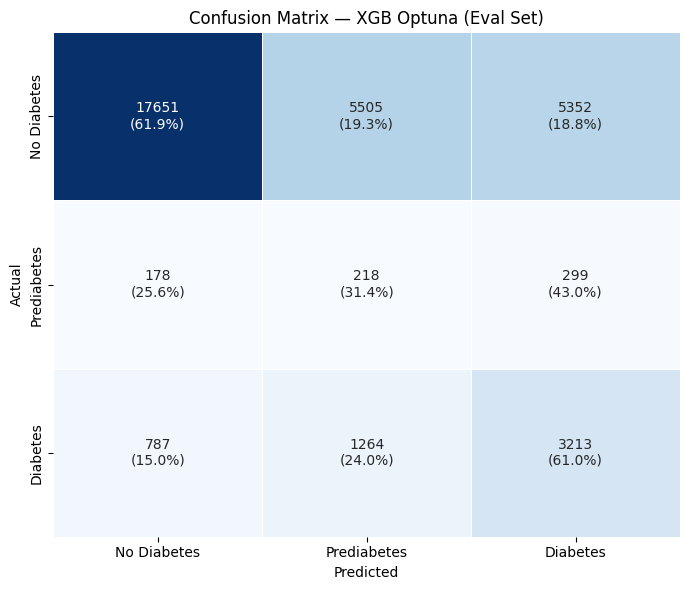

In [32]:
# ==========================
# Report-ready confusion matrix (counts + row %), XGB Optuna
# ==========================
from sklearn.metrics import confusion_matrix

class_names = ["No Diabetes", "Prediabetes", "Diabetes"]

# Confusion matrix (counts)
cm = confusion_matrix(y_eval, y_pred_opt, labels=[0, 1, 2])
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Row-normalized percentages
cm_row_pct = cm_df.div(cm_df.sum(axis=1), axis=0) * 100

# Combine counts + percentages for annotation
cm_annot = cm_df.astype(int).astype(str) + "\n(" + cm_row_pct.round(1).astype(str) + "%)"

# Display table (counts + row %) for direct copy into report
cm_table = cm_df.copy()
for r in cm_table.index:
    for c in cm_table.columns:
        cm_table.loc[r, c] = f"{cm_df.loc[r, c]} ({cm_row_pct.loc[r, c]:.1f}%)"

print("Confusion matrix (counts and row %):")
display(cm_table)

# Plot heatmap for report-ready figure
plt.figure(figsize=(7, 6))
sns.heatmap(
    cm_df,
    annot=cm_annot,
    fmt="",
    cmap="Blues",
    cbar=False,
    linewidths=0.5,
    linecolor="white"
 )
plt.title("Confusion Matrix — XGB Optuna (Eval Set)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
savefig("confusion_matrix_xgb_optuna_eval.png")
plt.show()

In [23]:
# Create functions for calibration and brier score
def brier_multiclass(y_true, y_proba, labels=(0,1,2)) -> float:
    """
    Multiclass Brier score:
    mean over samples of sum_k (p_k - y_k)^2, where y_k is one-hot.
    """
    Y = label_binarize(y_true, classes=list(labels))  # shape (n, K)
    P = np.asarray(y_proba)
    return float(np.mean(np.sum((P - Y) ** 2, axis=1)))

def prob_quality_metrics(y_true, y_proba, labels=(0,1,2)) -> dict:
    return {
        "log_loss": float(log_loss(y_true, y_proba, labels=list(labels))),
        "brier_multiclass": brier_multiclass(y_true, y_proba, labels=labels),
    }

In [24]:
# Recreate the tuned base model (clean + reproducible)
base_xgb_optuna = Pipeline(steps=[
    ("preprocess", preprocess_raw),
    ("clf", XGBClassifier(
        objective="multi:softprob",
        num_class=3,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1,
        **best_params
    ))
])

# Fit base model on TRAIN with sample weights
base_xgb_optuna.fit(X_train_raw, y_train, clf__sample_weight=sample_w_train)

# Pre-calibration probabilities on EVAL
proba_pre = base_xgb_optuna.predict_proba(X_eval_raw)
pre_metrics = prob_quality_metrics(y_eval, proba_pre, labels=(0,1,2))

rows = []
rows.append({
    "model_variant": "pre_calibration (optuna)",
    **pre_metrics
})

# Calibrate using TRAIN only (CV=3)
# Use sigmoid (Platt scaling)
cal_sigmoid = CalibratedClassifierCV(
    estimator=clone(base_xgb_optuna),
    method="sigmoid",
    cv=3
)
cal_sigmoid.fit(X_train_raw, y_train, sample_weight=sample_w_train)

proba_sig = cal_sigmoid.predict_proba(X_eval_raw)
sig_metrics = prob_quality_metrics(y_eval, proba_sig, labels=(0,1,2))
rows.append({
    "model_variant": "post_calibration (sigmoid, CV=3 on train)",
    **sig_metrics
})

# Isotonic (optional but good comparison)
cal_isotonic = CalibratedClassifierCV(
    estimator=clone(base_xgb_optuna),
    method="isotonic",
    cv=3
)
cal_isotonic.fit(X_train_raw, y_train, sample_weight=sample_w_train)

proba_iso = cal_isotonic.predict_proba(X_eval_raw)
iso_metrics = prob_quality_metrics(y_eval, proba_iso, labels=(0,1,2))
rows.append({
    "model_variant": "post_calibration (isotonic, CV=3 on train)",
    **iso_metrics
})

calibration_compare = pd.DataFrame(rows).sort_values("log_loss")
calibration_compare

/Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/.venv/lib/python3.12/site-packages/sklearn/calibration.py:394: UserWarning: Since Pipeline does not appear to accept sample_weight, sample weights will only be used for the calibration itself. This can be caused by a limitation of the current scikit-learn API. See the following issue for more details: https://github.com/scikit-learn/scikit-learn/issues/21134. Be warned that the result of the calibration is likely to be incorrect.
  warnings.warn(
/Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/.venv/lib/python3.12/site-packages/sklearn/calibration.py:394: UserWarning: Since Pipeline does not appear to accept sample_weight, sample weights will only be used for the calibration itself. This can be caused by a limitation of the current scikit-learn API. See the following issue for more details: https://github.com/scikit-learn/scikit-learn/issues/21134. Be warned that th

,model_variant,log_loss,brier_multiclass
0,pre_calibration (optuna),0.879014,0.500454
2,"post_calibration (isotonic, CV=3 on train)",0.880211,0.495443
1,"post_calibration (sigmoid, CV=3 on train)",0.910941,0.500569


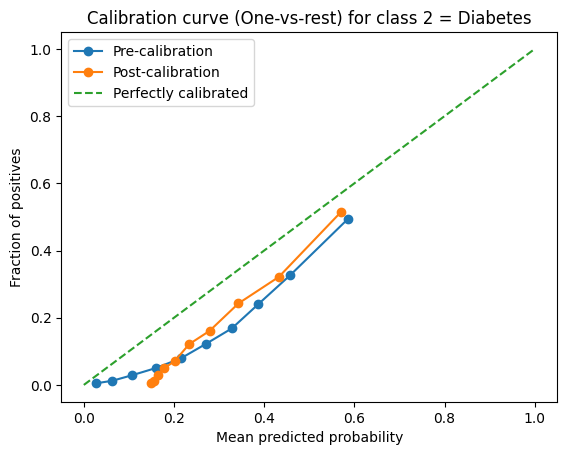

In [25]:

def plot_calibration_ovr(y_true, proba_pre, proba_post, class_label=2, n_bins=10, title=""):
    """
    One-vs-rest calibration curve for a chosen class.
    """
    y_bin = (np.asarray(y_true) == class_label).astype(int)

    frac_pos_pre, mean_pred_pre = calibration_curve(y_bin, proba_pre[:, class_label], n_bins=n_bins, strategy="quantile")
    frac_pos_post, mean_pred_post = calibration_curve(y_bin, proba_post[:, class_label], n_bins=n_bins, strategy="quantile")

    plt.figure()
    plt.plot(mean_pred_pre, frac_pos_pre, marker="o", label="Pre-calibration")
    plt.plot(mean_pred_post, frac_pos_post, marker="o", label="Post-calibration")
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title(title)
    plt.legend()
    plt.show()

# Choose which calibrated version to compare visually:
# If sigmoid had lower log_loss/brier, use proba_sig; otherwise use proba_iso.
proba_post_best = proba_sig  # change to proba_iso if isotonic is better

plot_calibration_ovr(
    y_eval,
    proba_pre,
    proba_post_best,
    class_label=2,
    n_bins=10,
    title="Calibration curve (One-vs-rest) for class 2 = Diabetes"
)

In [26]:
# ==========================
# Classification metrics pre vs post calibration (EVAL set)
# (include Brier + logloss explicitly)
# ==========================

# --- Pre-calibration (optuna model) ---
y_pred_pre = base_xgb_optuna.predict(X_eval_raw)
y_proba_pre = base_xgb_optuna.predict_proba(X_eval_raw)
metrics_pre_full = evaluate_multiclass_classifier(y_eval, y_pred_pre, y_proba_pre)

prob_pre = prob_quality_metrics(y_eval, y_proba_pre, labels=(0,1,2))  # has log_loss + brier

# --- Post-calibration (isotonic) ---
y_pred_iso = cal_isotonic.predict(X_eval_raw)
y_proba_iso = cal_isotonic.predict_proba(X_eval_raw)
metrics_iso_full = evaluate_multiclass_classifier(y_eval, y_pred_iso, y_proba_iso)

prob_iso = prob_quality_metrics(y_eval, y_proba_iso, labels=(0,1,2))

# comparison table for the report
compare_cols = [
    "recall_at_risk_1or2",
    "recall_class_1",
    "recall_class_2",
    "precision_class_2",
    "balanced_accuracy",
    "f1_macro",
]

pre_row = {"variant": "pre_calibration (optuna)", **{k: metrics_pre_full[k] for k in compare_cols}, **prob_pre}
iso_row = {"variant": "post_calibration (isotonic)", **{k: metrics_iso_full[k] for k in compare_cols}, **prob_iso}

pd.DataFrame([pre_row, iso_row])

,variant,recall_at_risk_1or2,recall_class_1,recall_class_2,precision_class_2,balanced_accuracy,f1_macro,log_loss,brier_multiclass
0,pre_calibration (optuna),0.838060,0.313669,0.610372,0.362477,0.514400,0.420242,0.879014,0.500454
1,post_calibration (isotonic),0.825642,0.234532,0.654635,0.371056,0.513568,0.432558,0.880211,0.495443


In [27]:
log_experiment(
    exp_id="XGB__raw__classweight__optuna__cal_isotonic",
    model_family="XGB",
    features="raw",
    sampling="classweight",
    tuning="optuna+cal(isotonic)",
    notes="Optuna-tuned XGB calibrated with isotonic regression (CV on train), evaluated on validation set",
    metrics=metrics_iso_full,
    params={"calibration": "isotonic", **base_xgb_optuna.get_params()}
)

results_df()

,experiment,model,features,sampling,tuning,notes,metric__accuracy,metric__balanced_accuracy,metric__f1_macro,metric__f1_weighted,metric__log_loss,metric__brier_score,metric__roc_auc_ovr_macro,metric__roc_auc_ovr_weighted,metric__roc_auc_ovo_macro,metric__precision_class_0,metric__recall_class_0,metric__f1_class_0,metric__support_class_0,metric__precision_class_1,metric__recall_class_1,metric__f1_class_1,metric__support_class_1,metric__precision_class_2,metric__recall_class_2,metric__f1_class_2,metric__support_class_2,metric__recall_at_risk_1or2,metric__precision_at_risk_1or2,metric__f1_at_risk_1or2
0,LR__raw__none__default,LR,raw,none,default,"Baseline LR on raw features (no class weighting), evaluated on validation set",0.832652,0.381569,0.388215,0.789474,0.430786,0.243558,0.768865,0.806276,0.691010,0.847366,0.975445,0.906906,28508,0.000000,0.000000,0.000000,695,0.540000,0.169263,0.257738,5264,0.159423,0.575758,0.249704
1,LR__raw__classweight__default,LR,raw,classweight,default,LogReg with class_weight='balanced' to address class imbalance (evaluated on validation set),0.629472,0.514638,0.426272,0.703388,0.904043,0.507792,0.760143,0.804891,0.700733,0.943133,0.643433,0.764977,28508,0.032617,0.303597,0.058906,695,0.367528,0.596884,0.454934,5264,0.814398,0.323146,0.462697
2,LR__featA__none__default,LR,featA,none,default,"LR on Feature Set A engineered features, no balancing (eval set)",0.832623,0.380112,0.386204,0.788598,0.430029,0.243049,0.769252,0.806558,0.691612,0.846769,0.976393,0.906973,28508,0.000000,0.000000,0.000000,695,0.541066,0.163944,0.251640,5264,0.154724,0.578056,0.244109
3,LR__featA__classweight__default,LR,featA,classweight,default,LR on Feature Set A with class_weight='balanced' (eval set),0.625932,0.517617,0.425656,0.700426,0.903397,0.508437,0.759986,0.805289,0.701405,0.944257,0.637575,0.761187,28508,0.033109,0.310791,0.059842,695,0.366000,0.604483,0.455939,5264,0.819936,0.321067,0.461444
4,RF__raw__none__default,RF,raw,none,default,"Random Forest baseline (raw features, eval set)",0.835437,0.377994,0.383454,0.788458,0.429008,0.240964,0.762769,0.807489,0.690417,0.845464,0.982005,0.908634,28508,0.000000,0.000000,0.000000,695,0.590406,0.151976,0.241728,5264,0.141299,0.621402,0.230243
5,XGB__raw__none__default,XGB,raw,none,default,Baseline XGBoost multiclass on raw features (eval set),0.837323,0.388563,0.398057,0.795777,0.421715,0.237510,0.776225,0.815324,0.700122,0.850369,0.977620,0.909566,28508,0.000000,0.000000,0.000000,695,0.584761,0.188070,0.284605,5264,0.177043,0.623154,0.275745
6,XGB__raw__classweight__default,XGB,raw,classweight,default,"XGBoost baseline with class-balanced sample weights (train only), eval set",0.615110,0.511926,0.421207,0.692410,0.865279,0.492477,0.757654,0.810910,0.701847,0.948489,0.622001,0.751308,28508,0.030146,0.293525,0.054677,695,0.362576,0.620251,0.457635,5264,0.838396,0.316764,0.459804
7,XGB__raw__classweight__optuna,XGB,raw,classweight,optuna,Optuna-tuned XGB with class-balanced sample weights; CV balanced_accuracy; evaluated on validation set,0.611658,0.514400,0.420242,0.690223,0.879014,0.500454,0.761756,0.811311,0.705406,0.948163,0.619160,0.749130,28508,0.031201,0.313669,0.056756,695,0.362477,0.610372,0.454841,5264,0.838060,0.315059,0.457955
8,XGB__raw__classweight__optuna__cal_isotonic,XGB,raw,classweight,optuna+cal(isotonic),"Optuna-tuned XGB calibrated with isotonic regression (CV on train), evaluated on validation set",0.643601,0.513568,0.432558,0.711892,0.880211,0.495443,0.775330,0.814397,0.704507,0.947025,0.651536,0.771971,28508,0.029280,0.234532,0.052060,695,0.371056,0.654635,0.473644,5264,0.825642,0.331224,0.472781


Figure saved: /Users/dawoodbutt/Desktop/10. UNI/4. Data Mining/individual assessment/diabetes-risk/figures/results_multi/roc_curves_xgb_calibrated.png


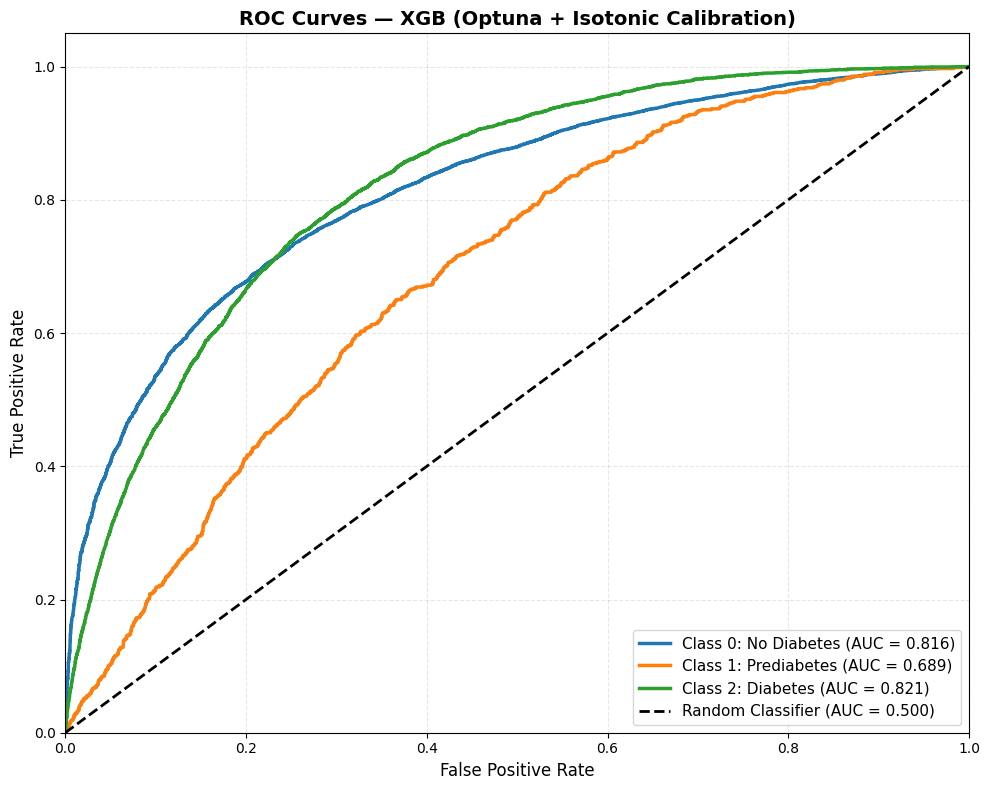


ROC-AUC Comparison: Pre vs Post Calibration


,Model,ROC-AUC (macro),ROC-AUC (weighted)
0,Pre-calibration,0.761756,0.811311
1,Post-calibration (Isotonic),0.775330,0.814397


In [28]:
# ==========================
# ROC-AUC Curves (One-vs-Rest) for Best Model
# ==========================

from sklearn.metrics import roc_curve, auc

def plot_multiclass_roc(y_true, y_proba, labels=(0,1,2), title="ROC Curves (One-vs-Rest)", save_name=None):
    """
    Plot ROC curves for each class in a multiclass problem (One-vs-Rest).
    Shows AUC score for each class.
    """
    # Binarize the output
    y_true_bin = label_binarize(y_true, classes=list(labels))
    n_classes = len(labels)
    
    # Class names for better readability
    class_names = {0: "No Diabetes", 1: "Prediabetes", 2: "Diabetes"}
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    
    plt.figure(figsize=(10, 8))
    
    # Plot ROC curve for each class
    for i, lbl in enumerate(labels):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        
        plt.plot(
            fpr, tpr, 
            color=colors[i],
            lw=2.5, 
            label=f'Class {lbl}: {class_names[lbl]} (AUC = {roc_auc:.3f})'
        )
    
    # Plot random classifier baseline
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.500)')
    
    # Formatting
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3, linestyle='--')
    plt.tight_layout()
    
    if save_name:
        savefig(save_name)
    
    plt.show()

# Plot ROC curves for calibrated model (isotonic)
plot_multiclass_roc(
    y_eval, 
    proba_iso, 
    labels=(0,1,2), 
    title="ROC Curves — XGB (Optuna + Isotonic Calibration)",
    save_name="roc_curves_xgb_calibrated.png"
)

# Optional: Compare pre vs post calibration
print("\n" + "="*60)
print("ROC-AUC Comparison: Pre vs Post Calibration")
print("="*60)

# Pre-calibration
roc_pre = roc_auc_score(y_eval, proba_pre, multi_class="ovr", average="macro")
roc_pre_weighted = roc_auc_score(y_eval, proba_pre, multi_class="ovr", average="weighted")

# Post-calibration (isotonic)
roc_post = roc_auc_score(y_eval, proba_iso, multi_clascs="ovr", average="macro")
roc_post_weighted = roc_auc_score(y_eval, proba_iso, multi_class="ovr", average="weighted")

comparison = pd.DataFrame({
    "Model": ["Pre-calibration", "Post-calibration (Isotonic)"],
    "ROC-AUC (macro)": [roc_pre, roc_post],
    "ROC-AUC (weighted)": [roc_pre_weighted, roc_post_weighted]
})

display(comparison)